In [34]:

import torch, platform
print("Torch:", torch.__version__, "| CUDA runtime in torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
    print("Compute capability:", torch.cuda.get_device_capability(0))
try:
    import torchvision
    print("Torchvision:", torchvision.__version__)
except Exception as e:
    print("Torchvision import error:", e)


Torch: 2.3.1 | CUDA runtime in torch: 12.1
CUDA available: True
Device: NVIDIA GeForce GTX 1050 Ti
Compute capability: (6, 1)
Torchvision: 0.18.1



# U-Net Segmentation (Oxford-IIIT Pet, Binary) — PyTorch

This notebook trains a compact **U-Net** on the **Oxford-IIIT Pet** dataset to segment **pet vs background**.
It saves side-by-side panels (**Image | GT Mask | Prediction | Overlay**) for easy interpretation and comparison.

**Quick tips:**  
- Designed to run on a 4GB GPU (e.g., GTX 1050 Ti) with `img_size=256`, `batch_size=8`.  
- If you get CUDA OOM, reduce batch size or image size.  
- Dataset auto-downloads to `data/oxford-iiit-pet/`.


## 1. Setup (install deps — run once)

In [35]:

# If you're in a fresh environment, uncomment and run:
%pip install tqdm numpy matplotlib opencv-python Pillow


Note: you may need to restart the kernel to use updated packages.


## 2. Imports & Globals

In [36]:

import os, glob, time, math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from torchvision.datasets.utils import download_and_extract_archive
from tqdm import tqdm

# Paths & hyperparams
ROOT = "data"                 # dataset root
OUTDIR = "outputs"            # where to save checkpoints & panels
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 10
LR = 3e-4
BASE_CH = 32

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 3. Dataset & Dataloaders (Oxford-IIIT Pet → binary masks)

In [37]:

PET_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
ANN_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

class OxfordPetSegDataset(Dataset):
    """Binary segmentation: pet (1) vs background (0)
    Uses Oxford-IIIT Pet 'images' and 'annotations/trimaps'
    """
    def __init__(self, root, split="train", img_size=256):
        super().__init__()
        self.root = os.path.abspath(root)
        self.img_size = img_size

        base = os.path.join(self.root, "oxford-iiit-pet")
        images_dir = os.path.join(base, "images")
        ann_dir    = os.path.join(base, "annotations")

        # Download if missing
        if not (os.path.isdir(images_dir) and os.path.isdir(ann_dir)):
            os.makedirs(base, exist_ok=True)
            print("Downloading Oxford-IIIT Pet...")
            download_and_extract_archive(PET_URL, base)
            download_and_extract_archive(ANN_URL, base)

        # Collect images/masks with matching stems
        imgs = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
        masks = sorted(glob.glob(os.path.join(ann_dir, "trimaps", "*.png")))
        img_map = {os.path.splitext(os.path.basename(p))[0]: p for p in imgs}

        images, trimaps = [], []
        for m in masks:
            stem = os.path.splitext(os.path.basename(m))[0]
            if stem in img_map:
                images.append(img_map[stem])
                trimaps.append(m)
        self.images, self.trimaps = images, trimaps

        # Simple deterministic split 90/10
        rng = np.random.default_rng(123)
        idx = np.arange(len(images))
        rng.shuffle(idx)
        split_pt = int(0.9 * len(idx))
        train_idx, val_idx = idx[:split_pt], idx[split_pt:]
        self.indices = train_idx if split == "train" else val_idx

        # Precompute normalization tensors
        self.mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
        self.std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None]

    def __len__(self):
        return len(self.indices)

    def _load_pair(self, i):
        img_path = self.images[i]
        msk_path = self.trimaps[i]
        img = Image.open(img_path).convert("RGB")
        msk = Image.open(msk_path)  # trimap labels in {1,2,3}
        return img, msk

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, msk = self._load_pair(real_idx)

        # Resize
        img = TF.resize(img, [self.img_size, self.img_size], InterpolationMode.BILINEAR)
        msk = TF.resize(msk, [self.img_size, self.img_size], InterpolationMode.NEAREST)

        # To tensors
        img = TF.to_tensor(img)                         # [0,1]
        msk_np = np.array(msk, dtype=np.uint8)
        bin_mask = (msk_np == 1).astype(np.float32)     # class=1 → pet
        msk = torch.from_numpy(bin_mask)[None, ...]     # (1,H,W)

        # Random horizontal flip
        if np.random.rand() < 0.5:
            img = torch.flip(img, dims=[2])
            msk = torch.flip(msk, dims=[2])

        # Normalize
        img = (img - self.mean) / self.std
        return img, msk

def make_loaders(root, img_size=256, batch_size=8, num_workers=2):
    train_ds = OxfordPetSegDataset(root, split="train", img_size=img_size)
    val_ds   = OxfordPetSegDataset(root, split="val",   img_size=img_size)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader

train_loader, val_loader = make_loaders(ROOT, IMG_SIZE, BATCH_SIZE, num_workers=2)
len(train_loader.dataset), len(val_loader.dataset)


(6651, 739)

## 4. U-Net Model

In [38]:
# --- Model blocks ---
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): 
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    """Upsample + concat with skip, then DoubleConv(up_ch + skip_ch -> out_ch)."""
    def __init__(self, up_ch, skip_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(up_ch, up_ch, kernel_size=2, stride=2)
        # IMPORTANT: expect up_ch + skip_ch after cat
        self.conv = DoubleConv(up_ch + skip_ch, out_ch)

    def forward(self, x_up, x_skip):
        x_up = self.up(x_up)
        # pad to match spatial dims (handles odd sizes)
        dy, dx = x_skip.size(2) - x_up.size(2), x_skip.size(3) - x_up.size(3)
        if dy != 0 or dx != 0:
            x_up = F.pad(x_up, [dx//2, dx - dx//2, dy//2, dy - dy//2])
        x = torch.cat([x_skip, x_up], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32, bilinear=True):
        super().__init__()
        # Encoder
        self.inc   = DoubleConv(in_ch, base)            # 3  -> 32
        self.down1 = Down(base,   base*2)               # 32 -> 64
        self.down2 = Down(base*2, base*4)               # 64 -> 128
        self.down3 = Down(base*4, base*8)               # 128-> 256
        self.down4 = Down(base*8, base*16)              # 256-> 512
        # Decoder: Up(up_ch, skip_ch, out_ch)
        self.up1 = Up(base*16, base*8,  base*8,  bilinear)  # (512,256)->256
        self.up2 = Up(base*8,  base*4,  base*4,  bilinear)  # (256,128)->128
        self.up3 = Up(base*4,  base*2,  base*2,  bilinear)  # (128, 64)-> 64
        self.up4 = Up(base*2,  base,     base,   bilinear)  # ( 64, 32)-> 32
        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x1 = self.inc(x)        # 32
        x2 = self.down1(x1)     # 64
        x3 = self.down2(x2)     # 128
        x4 = self.down3(x3)     # 256
        x5 = self.down4(x4)     # 512
        u1 = self.up1(x5, x4)   # 512 + 256 = 768 -> 256
        u2 = self.up2(u1, x3)   # 256 + 128 = 384 -> 128
        u3 = self.up3(u2, x2)   # 128 +  64 = 192 ->  64
        u4 = self.up4(u3, x1)   #  64 +  32 =  96 ->  32
        return self.outc(u4)

## 5. Losses & Metrics (BCE + Dice, IoU/Dice scores)

In [39]:
# --- Losses/metrics (same as you had) ---
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2 * (probs * targets).sum(dim=(2,3)) + self.eps
        den = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.eps
        dice = (num / den).mean()
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.w = bce_weight
    def forward(self, logits, targets):
        return self.w * self.bce(logits, targets) + (1 - self.w) * self.dice(logits, targets)

@torch.no_grad()
def binarize(logits, thresh=0.5):
    return (torch.sigmoid(logits) > thresh).float()

@torch.no_grad()
def iou_score(logits, targets, eps=1e-6):
    preds = binarize(logits)
    inter = (preds * targets).sum(dim=(2,3))
    union = (preds + targets).clamp_max(1).sum(dim=(2,3))
    return ((inter + eps) / (union + eps)).mean().item()

@torch.no_grad()
def dice_score(logits, targets, eps=1e-6):
    preds = binarize(logits)
    num = 2 * (preds * targets).sum(dim=(2,3))
    den = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    return ((num + eps) / (den + eps)).mean().item()

loss_fn = BCEDiceLoss(0.5)

## 6. Train

In [40]:
model = UNet(in_ch=3, out_ch=1, base=BASE_CH, bilinear=True).to(device)

os.makedirs(os.path.join(OUTDIR, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(OUTDIR, "logs"), exist_ok=True)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

best_iou = 0.0
history = {"train_loss": [], "val_loss": [], "val_iou": [], "val_dice": []}

# --- Training loop ---
for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]")
    for imgs, masks in pbar:
        imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            logits = model(imgs)
            loss = loss_fn(logits, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item() * imgs.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    train_loss = running / len(train_loader.dataset)

    # Validate
    model.eval()
    v_running = 0.0
    v_iou = v_dice = 0.0
    v_count = 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]"):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            v_running += loss_fn(logits, masks).item() * imgs.size(0)
            v_iou  += iou_score(logits, masks) * imgs.size(0)
            v_dice += dice_score(logits, masks) * imgs.size(0)
            v_count += imgs.size(0)
    val_loss = v_running / v_count
    val_iou  = v_iou / v_count
    val_dice = v_dice / v_count

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_iou)
    history["val_dice"].append(val_dice)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | IoU={val_iou:.4f} | Dice={val_dice:.4f}")

    # Save best
    if val_iou > best_iou:
        best_iou = val_iou
        ckpt = os.path.join(OUTDIR, "checkpoints", "best.pt")
        torch.save({
            "model": model.state_dict(),
            "epoch": epoch,
            "val_iou": best_iou,
            "hparams": {
                "IMG_SIZE": IMG_SIZE, "BATCH_SIZE": BATCH_SIZE, "LR": LR, "BASE_CH": BASE_CH
            }
        }, ckpt)
        print(f"  ✓ Saved best checkpoint to {ckpt} (IoU {best_iou:.4f})")

Epoch 1/10 [val]: 100%|██████████| 93/93 [00:11<00:00,  8.39it/s]


Epoch 1: train_loss=0.4071 | val_loss=0.3277 | IoU=0.6311 | Dice=0.7571
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.6311)


Epoch 2/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.74it/s]


Epoch 2: train_loss=0.2760 | val_loss=0.2302 | IoU=0.7154 | Dice=0.8240
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.7154)


Epoch 3/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.66it/s]


Epoch 3: train_loss=0.2331 | val_loss=0.1962 | IoU=0.7566 | Dice=0.8521
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.7566)


Epoch 4/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.55it/s]


Epoch 4: train_loss=0.2078 | val_loss=0.1915 | IoU=0.7642 | Dice=0.8583
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.7642)


Epoch 5/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.57it/s]


Epoch 5: train_loss=0.1906 | val_loss=0.1660 | IoU=0.7882 | Dice=0.8747
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.7882)


Epoch 6/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.64it/s]


Epoch 6: train_loss=0.1808 | val_loss=0.1795 | IoU=0.7722 | Dice=0.8642


Epoch 7/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Epoch 7: train_loss=0.1692 | val_loss=0.1571 | IoU=0.7991 | Dice=0.8812
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.7991)


Epoch 8/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.56it/s]


Epoch 8: train_loss=0.1596 | val_loss=0.1573 | IoU=0.7998 | Dice=0.8812
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.7998)


Epoch 9/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Epoch 9: train_loss=0.1525 | val_loss=0.1403 | IoU=0.8168 | Dice=0.8934
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.8168)


Epoch 10/10 [val]: 100%|██████████| 93/93 [00:10<00:00,  8.61it/s]


Epoch 10: train_loss=0.1456 | val_loss=0.1389 | IoU=0.8183 | Dice=0.8947
  ✓ Saved best checkpoint to outputs/checkpoints/best.pt (IoU 0.8183)


## 7. Plot training curves

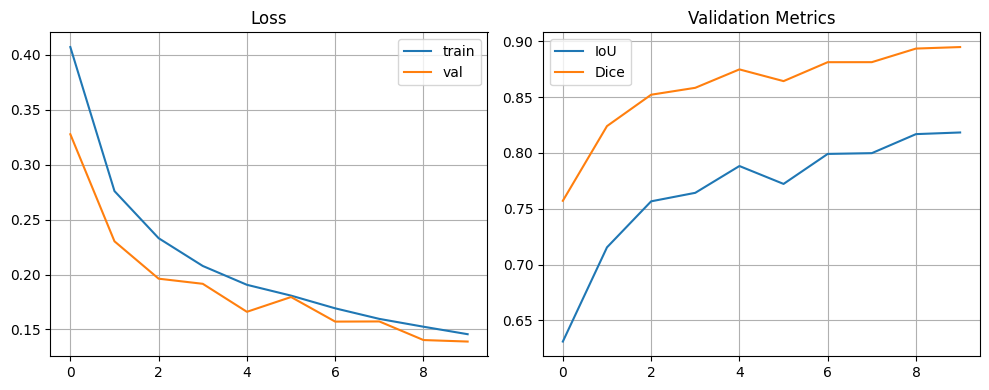

In [41]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.title("Loss"); plt.legend(); plt.grid(True)
plt.subplot(1,2,2); plt.plot(history["val_iou"], label="IoU"); plt.plot(history["val_dice"], label="Dice"); plt.title("Validation Metrics"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


## 8. Visualize predictions (side-by-side panels)

In [42]:

import cv2

def colorize_mask(mask):
    colored = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    colored[mask == 1] = (255, 0, 0)  # red
    return colored

def overlay(image, mask, alpha=0.5):
    color = colorize_mask(mask)
    over = cv2.addWeighted(image, 1.0, color, alpha, 0)
    return over

@torch.no_grad()
def logits_to_mask(logits, thresh=0.5):
    probs = torch.sigmoid(logits)
    return (probs > thresh).float()

def de_normalize(img_t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(img_t.device)
    std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(img_t.device)
    return (img_t * std + mean).clamp(0,1)

def save_panel(img, gt, pred, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.figure(figsize=(10, 6), dpi=140)
    plt.subplot(2,2,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(colorize_mask(gt)); plt.title("GT Mask"); plt.axis("off")
    plt.subplot(2,2,3); plt.imshow(colorize_mask(pred)); plt.title("Pred Mask"); plt.axis("off")
    plt.subplot(2,2,4); plt.imshow(overlay(img, pred)); plt.title("Overlay (Pred)"); plt.axis("off")
    plt.tight_layout(); plt.show()


## 9. Load best checkpoint & show some samples

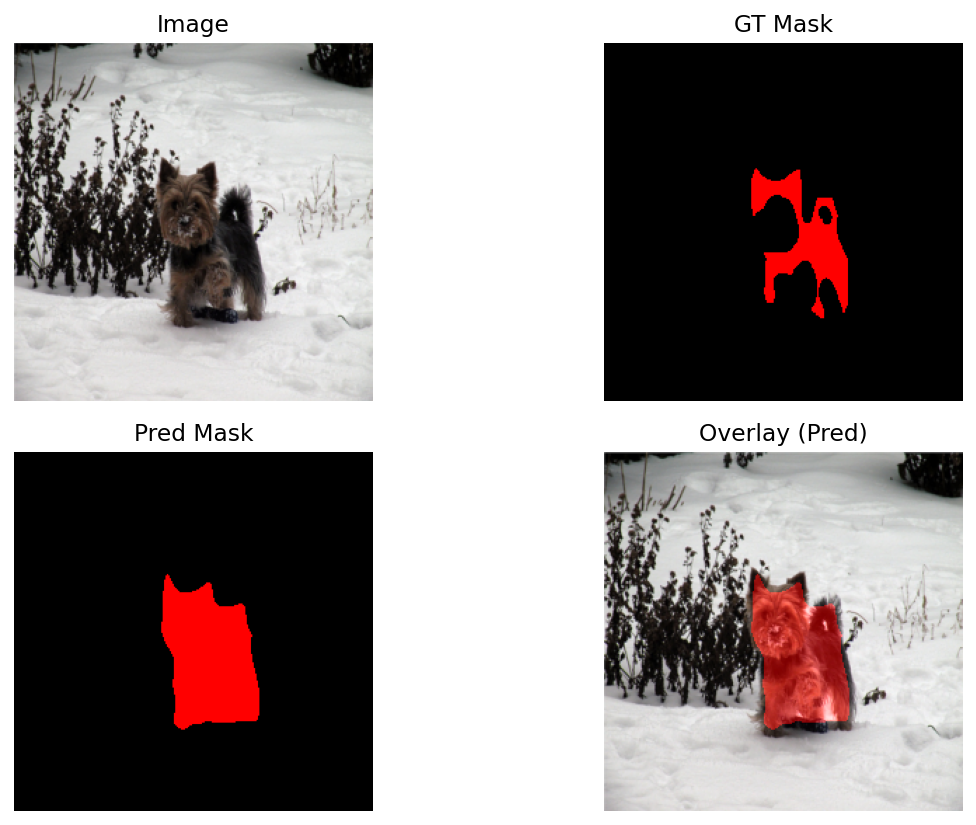

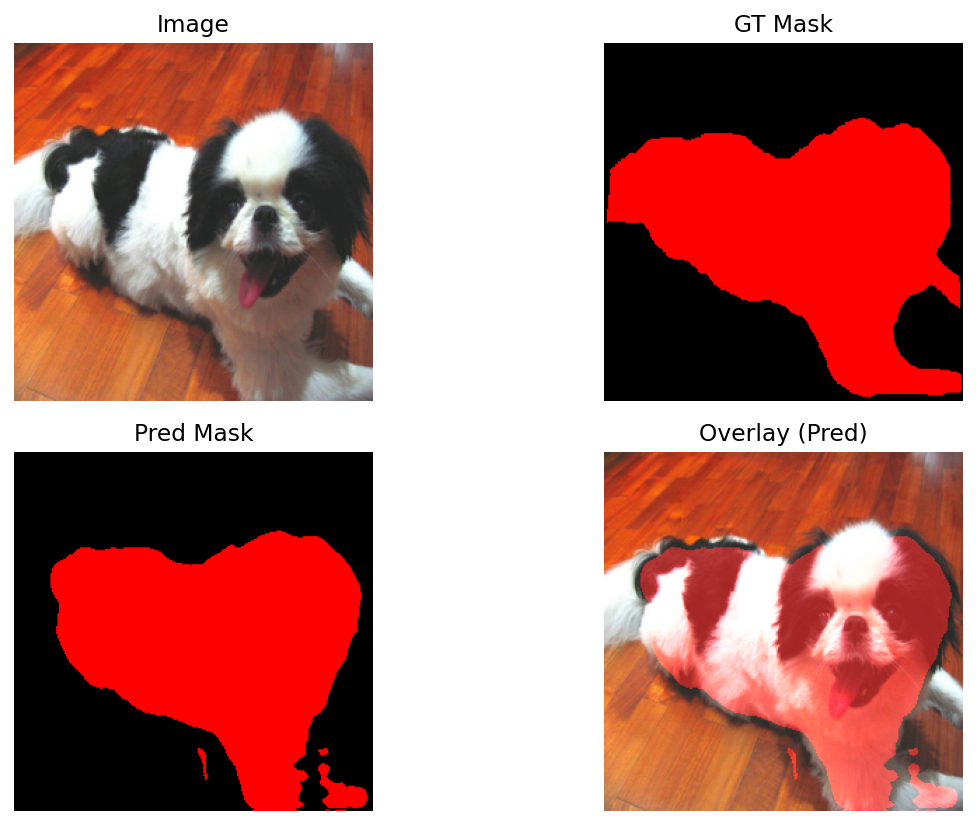

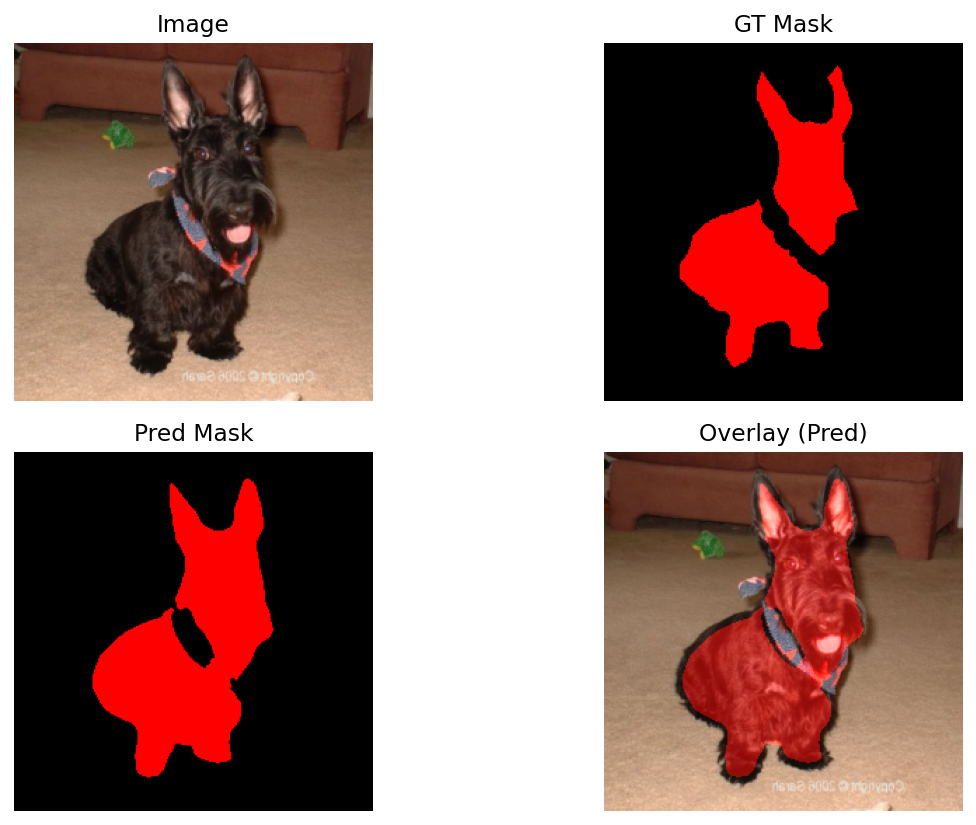

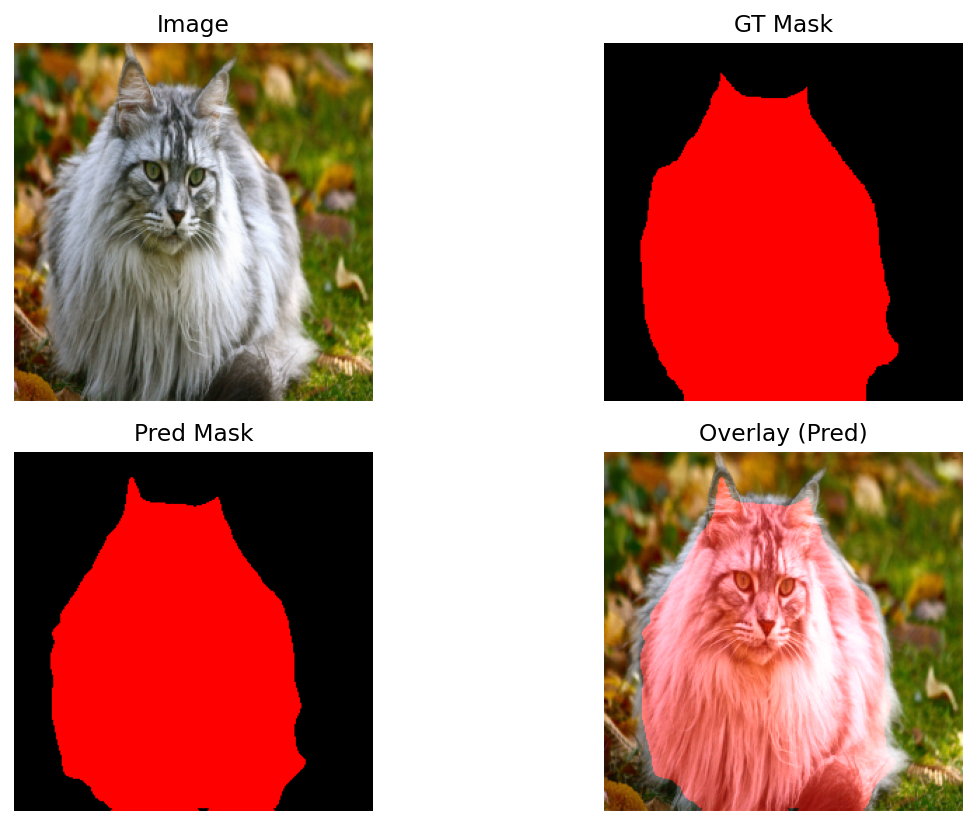

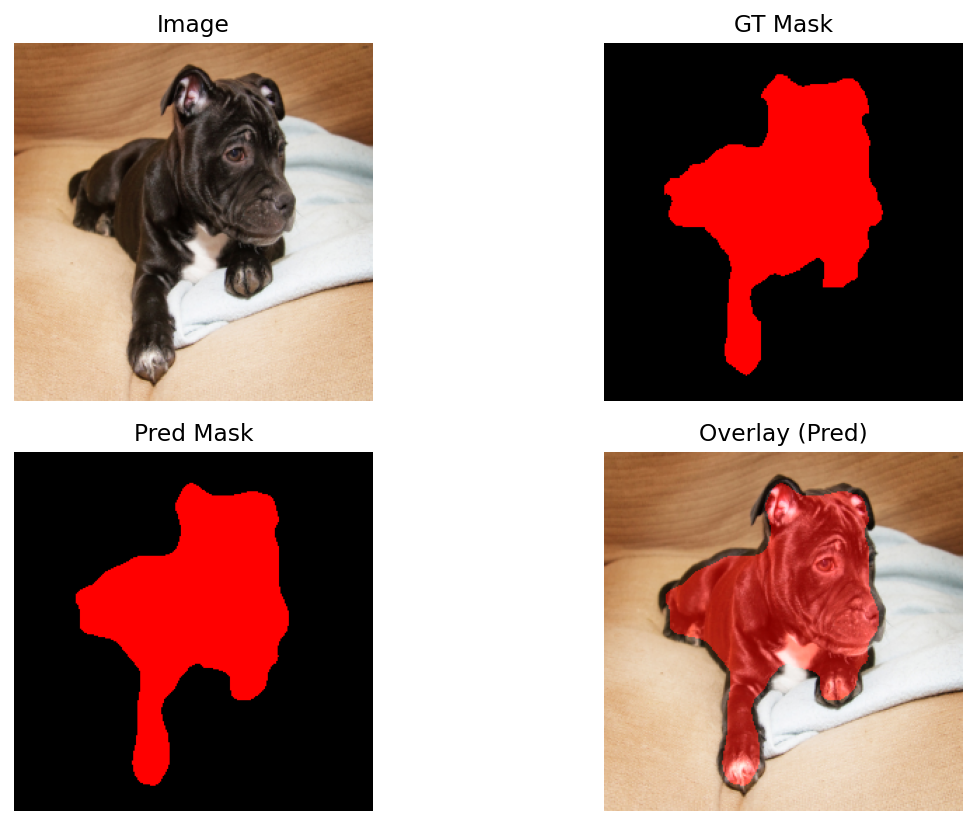

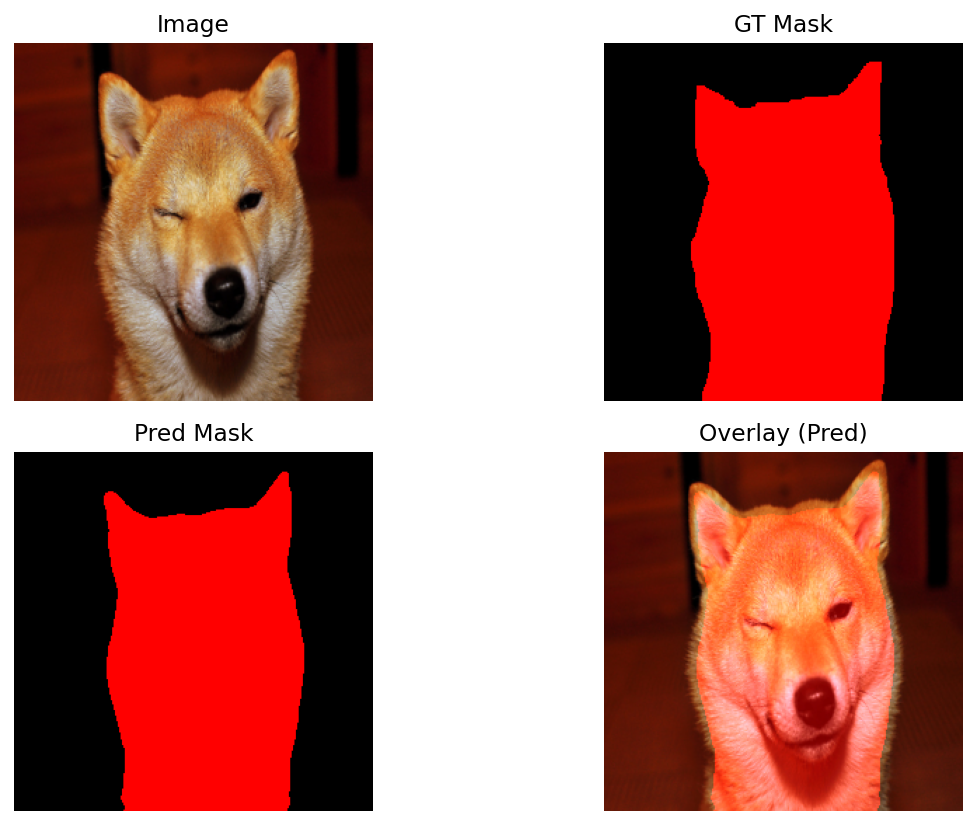

Done. Samples also saved under: outputs/samples


In [43]:

# Reload model from best checkpoint
ckpt_path = os.path.join(OUTDIR, "checkpoints", "best.pt")
ckpt = torch.load(ckpt_path, map_location=device)
best_model = UNet(in_ch=3, out_ch=1, base=BASE_CH).to(device)
best_model.load_state_dict(ckpt["model"])
best_model.eval()

# Run a few validation batches and visualize
shown = 0
max_show = 6  # change to see more
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = best_model(imgs)
        preds = logits_to_mask(logits)
        for i in range(imgs.size(0)):
            if shown >= max_show: break
            img = (de_normalize(imgs[i]).permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
            gt  = masks[i,0].cpu().numpy().astype(np.uint8)
            pr  = preds[i,0].cpu().numpy().astype(np.uint8)
            save_panel(img, gt, pr, save_path=os.path.join(OUTDIR, "samples", f"sample_{shown:03d}.png"))
            shown += 1
        if shown >= max_show: break

print("Done. Samples also saved under:", os.path.join(OUTDIR, "samples"))
